# Segment Blood Vessels
by Jeff Benshetler  

<h2>Goal: Segment blood vessel images. </h2>

<h3> Inputs:</h3> 
  - Gray scale image from which to segement blood vessels 
  - Regions image, a version of gray scale image with a red boundary identifying the type of region to segment.  

| Image To Segment | Regions Image    |
| ---------------- | ---------------- |
| ![Input Image](input/input_small.png "Input Image") | ![Reference Image](input/regions_small.png "Regions Image") | 


<h3> Output:</h3>
Gray scale image with white indicating that pixel is categorized as a blood vessel, black otherwise. 

## Approaches
 1. Grabcut segmentation - A defined region of the type of interest suggests that Grabcut could work.
 1. Morphological filtering might work, as this approach is employed with retinal vessels. However, this is more about cleaning up segmentation made from the green/red channels in a color image than crearing an initial segmentation.
 1. Variance filtering, used to compare the variance within the defined region vs. outside. This is a possible approach.
 1. Mutual information - testing for histogram similarity with the histogram of the blocked region

# Preliminaries

## Libraries

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Type hinting

In [2]:
from numpy.typing import NDArray
from typing import List, Tuple

In [3]:
def print_info(name : str, var : NDArray ) -> None:
    print(f"{name}.shape={var.shape} {name}.dtype={var.dtype}")

In [4]:
def show_image(img : NDArray, title : str, dpi : int = 90, colormap : str = 'gray') -> None:
    plt.figure(figsize=(16,9), dpi=dpi)
    _ = plt.imshow(img, colormap)
    _ = plt.title(title) 

In [5]:
def show_images(imgs : List[NDArray], suptitle : str = None, subtitles : list = None, dpi : int = 90):
    """_summary_
    Show 1 or more images in a subplot
    Args:
        imgs (List[NDArray]): _description_ List of images to `plt.imshow`
        suptitle (str, optional): _description_. Defaults to None. Top title, if provided.
        subtitles (list, optional): _description_. Defaults to None. Per-image titles.
        dpi (int, optional): _description_. Defaults to 90. Controls image size. 
    """
    fig = plt.figure(figsize=(16,9), dpi=dpi)
    N = len(imgs)
    for index, img in enumerate(imgs):
        ax = plt.subplot(1,N,index+1)
        if subtitles:
            plt.gca().set_title(subtitles[index])
        plt.imshow(img, 'gray')
    if suptitle is not None:
        fig.suptitle(suptitle, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

In [6]:
def histogram_plot(img : NDArray, title : str = None, dpi : int = 90):
    hist, bins = np.histogram( img.ravel(), bins=256, range=[0,256])
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(bins[:-1], hist / hist.sum())
    if title:
        plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    return bins[:-1], hist

# Inputs

## Read

In [19]:
input_img = cv2.cvtColor(
    cv2.imread('drive/DRIVE/test/images/01_test.tif'),
    cv2.COLOR_RGB2BGR
)
print_info('input',input_img)

input.shape=(584, 565, 3) input.dtype=uint8


In [20]:
regions_img = cv2.cvtColor(
    cv2.imread('input/regions.png'),
    cv2.COLOR_RGB2BGR
)
print_info('regions_img',regions_img)

regions_img.shape=(400, 322, 3) regions_img.dtype=uint8


## Preview Inputs

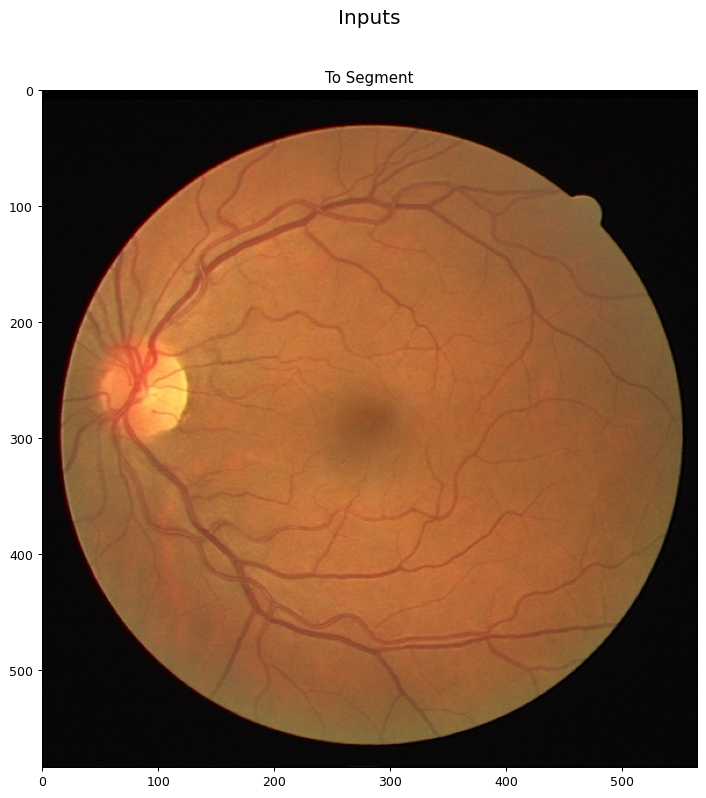

In [21]:
show_images([input_img], "Inputs", ["To Segment"])

# Morphology
Can we segment the vessels using structuring operations? This is a challenge, because we do not have strong FG/BG segmentation like we can get using multiple color channels in a retinal image.

In [22]:
def morphology(test_image : NDArray, subtitle : str = "morpho input", structuring_elements :List[tuple] = [(5,5), (11,11), (23,23)], dpi : int = 90) -> NDArray:
    # based on https://github.com/sachinmb27/Contour-Based-Blood-Vessel-Segmentation-in-Retinal-Fundus-Images/blob/main/segmentation.py
    
    #test image is converted to LAB modal
    lab = cv2.cvtColor(test_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    #Contrast Limited Adaptive Histogram Equalization is applied
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))

    #LAB modal converted back to RGB
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    #applying alternate sequential filtering
    blue,green,red = cv2.split(final)
    
    close = green.copy()
    open = None
    for se in structuring_elements:
        open = cv2.morphologyEx(close, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, se), iterations = 1)
        close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, se), iterations = 1)
    f4 = cv2.subtract(close, green)
    f5 = clahe.apply(f4)
    
    #tophat morphological transformation
    
    filterSize =(5, 5) 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                    filterSize) 
    # Applying the Black-Hat operation 
    topHat = cv2.morphologyEx(f5,  
                                cv2.MORPH_TOPHAT, 
                                kernel) 
    
    show_images([f5,topHat],["f5","topHat"])
    
    
    # image1 = f5
    # e_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, structuring_elements[0])
    # closeImg = cv2.morphologyEx(image1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, structuring_elements[0]), iterations = 1)
    # revImg = closeImg
    # show_images([f5,closeImg],["f5","closeImg"])
    # topHat = image1 - revImg
    # show_images([image1,revImg, topHat],["image1","revImg", "topHat"])

    #otsu with probability and minimization function
    imge = f5
    blur = cv2.GaussianBlur(imge, structuring_elements[0], 0)
    hist = cv2.calcHist([blur], [0], None, [256], [0,256])
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    for i in range(1, 256):
        p1, p2 = np.hsplit(hist_norm, [i]) #probabilities
        q1, q2 = Q[i],Q[255]-Q[i] #cum sum of classes
        b1, b2 = np.hsplit(bins,[i]) #weights

    #finding means and variances
    if q1 == 0:
        q1 = 0.0000001
    if q2 == 0:
        q2 = 0.0000001
    m1, m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1, v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    #calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

    #find otsu&'s threshold value with OpenCV function
    ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    show_images([green,otsu], "Morphology", [subtitle, "otsu"], dpi=dpi)

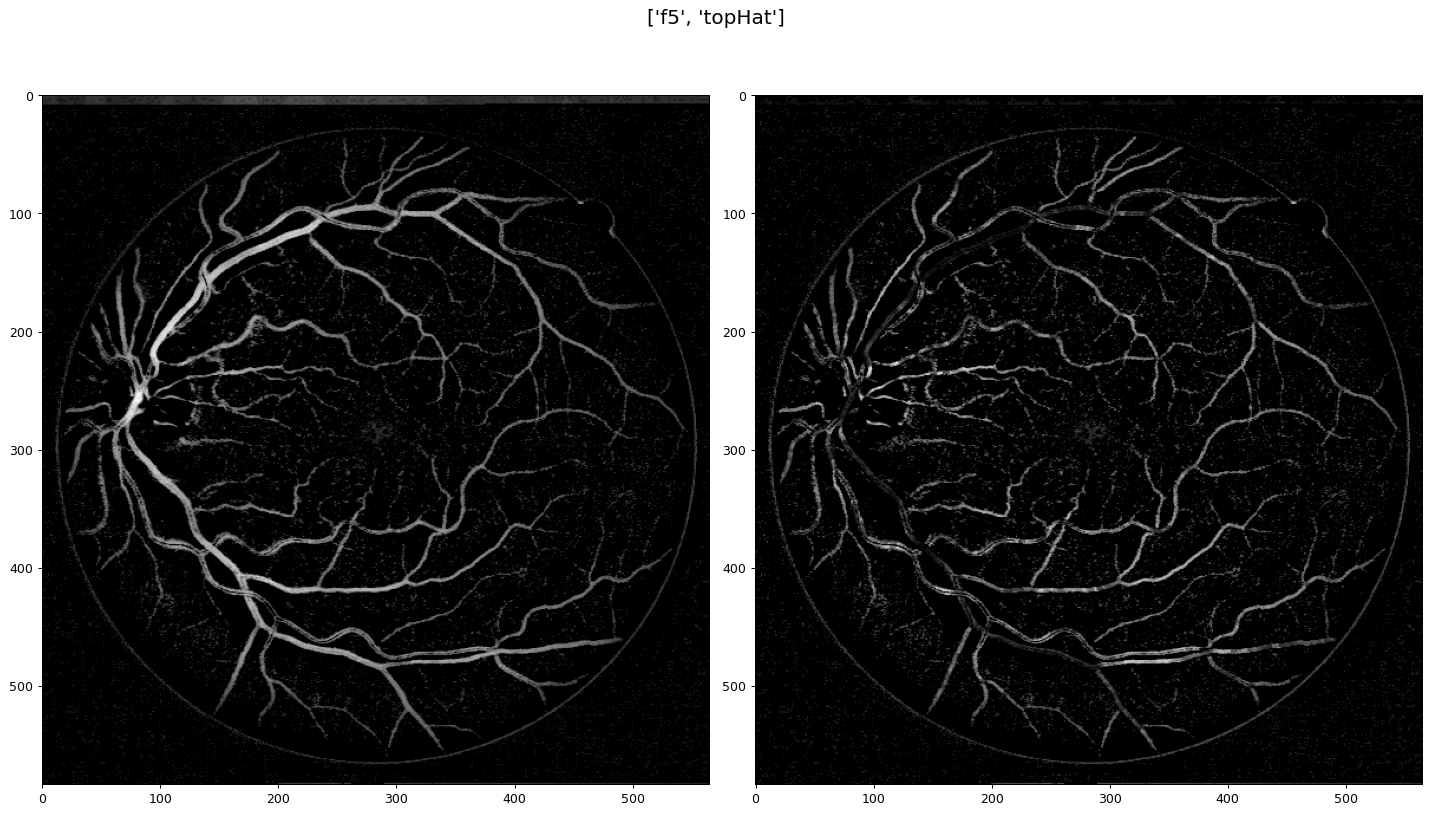

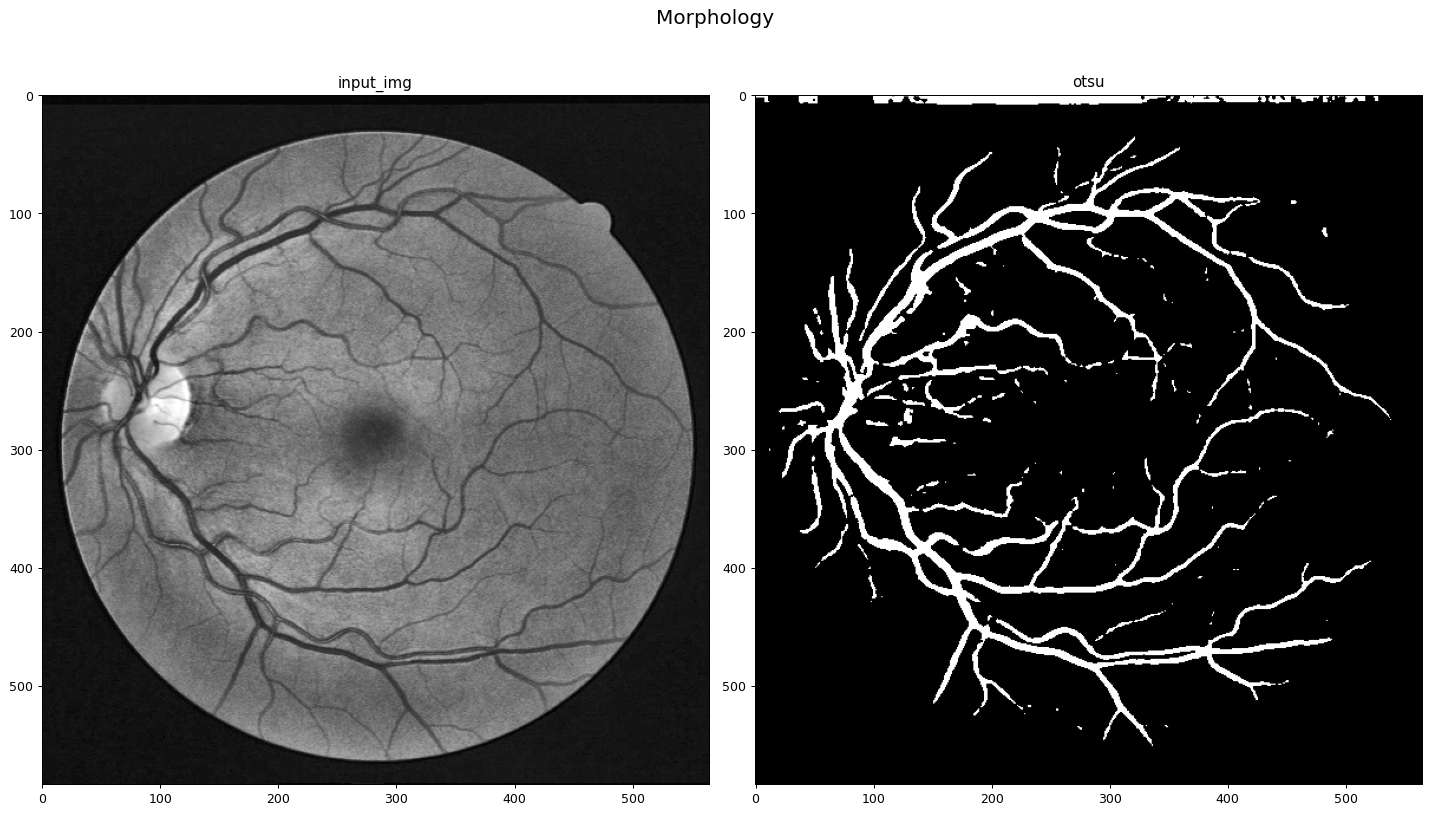

In [23]:
morphology(input_img, "input_img")

In [52]:
class ExtractArteries:
    def __init__(
        self,
        structuring_elements : List[tuple] = [(5,5), (11,11), (23,23)], 
        dpi : int = 90,
        show : bool = False
    ):
        self.structuring_elements = structuring_elements
        self.dpi = dpi
        self.show = show
        self.clahe = cv2.createCLAHE(clipLimit=3.0)
    
    def color_filter(self, test_image : NDArray) -> NDArray:
        #test image is converted to LAB modal
        lab = cv2.cvtColor(test_image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        #Contrast Limited Adaptive Histogram Equalization is applied
        clahe = cv2.createCLAHE(clipLimit=3.0)
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))

        #LAB modal converted back to RGB
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
        blue,green,red = cv2.split(final)
        return green
    
    def large_arteries(self, test_image : NDArray) -> NDArray:
        close = test_image.copy()
        open = None
        for se in self.structuring_elements:
            open = cv2.morphologyEx(
                    close, 
                    cv2.MORPH_OPEN, 
                    cv2.getStructuringElement(
                        cv2.MORPH_ELLIPSE, 
                        se
                    ),
                    iterations = 1
                )
            close = cv2.morphologyEx(
                    open,
                    cv2.MORPH_CLOSE,
                    cv2.getStructuringElement(
                        cv2.MORPH_ELLIPSE, 
                        se
                    ), 
                    iterations = 1
                )
        f4 = cv2.subtract(close, test_image)
        f5 = self.clahe.apply(f4)
        if self.show:
            show_images([test_image, f5], "large arteries", ["test_image", "CLAHE"])
            _ = histogram_plot(f5,"CLAHE Histogram")
        return f5
    
    def thresh(self, image : NDArray) -> NDArray:
        mean = np.mean( image.astype(np.float32) )
        sd = np.std(image.astype(np.float32) )
        print(f"mean={mean} sd={sd}")
        lower_bound = np.clip( mean - 2*sd, 0, None)
        print(f"lower_bound={lower_bound}")
        _, thr = cv2.threshold(image, mean, 255, cv2.THRESH_BINARY)
        print_info("thr", thr)
        if self.show:
            show_image(thr, "threshold")
        return thr
    
    def tophat(self, image1 : NDArray) -> NDArray:
        #tophat morphological transformation
        e_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        closeImg = cv2.morphologyEx(image1, cv2.MORPH_CLOSE, e_kernel)
        revImg = closeImg
        topHat = image1 - revImg
        if self.show:
            show_image(topHat, "topHat")
        return topHat
    
    def threshold(self, image : NDArray) -> NDArray:
        #otsu with probability and minimization function
        blur = cv2.GaussianBlur(image, (5,5), 0)
        hist = cv2.calcHist([blur], [0], None, [256], [0,256])
        hist_norm = hist.ravel()/hist.max()
        Q = hist_norm.cumsum()
        bins = np.arange(256)
        fn_min = np.inf
        thresh = -1
        for i in range(1, 256):
            p1, p2 = np.hsplit(hist_norm, [i]) #probabilities
            q1, q2 = Q[i],Q[255]-Q[i] #cum sum of classes
            b1, b2 = np.hsplit(bins,[i]) #weights

        #finding means and variances
        if q1 == 0:
            q1 = 0.0000001
        if q2 == 0:
            q2 = 0.0000001
        m1, m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1, v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

        #calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i

        #find otsu&'s threshold value with OpenCV function
        ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        if self.show:
            show_image(otsu, "Otsu")
        return otsu
    
    def small_contour_removal(self, image : NDArray) -> NDArray:
        ret, f6 = cv2.threshold(image, 15, 255, cv2.THRESH_BINARY)

        mask = np.ones(image.shape[:2], dtype='uint8') * 255
        contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) <= 255:
                cv2.drawContours(mask, [cnt], -1, 0, -1)
        im = cv2.bitwise_and(image, image, mask=mask)
        ret, fin = cv2.threshold(im, 15, 255, cv2.THRESH_BINARY_INV)
        newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)), iterations=1)
        if self.show:
            show_image(newfin, "small_contour_removal")
        return newfin
    
    def blob_removal(self, image : NDArray) -> NDArray:
        fundus_eroded = cv2.bitwise_not(image)
        xmask = np.ones(fundus_eroded.shape[:2], dtype='uint8') * 255
        x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in xcontours:
            shape = 'unidentified'
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
            if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
                shape = 'circle'
            else:
                shape = 'vessels'
            
            if(shape == 'circle'):
                cv2.drawContours(xmask, [cnt], -1, 0, -1)

        finimage = cv2.bitwise_and(fundus_eroded, fundus_eroded, mask=xmask)
        blood_vessels = cv2.bitwise_not(finimage)
        kernel = np.ones((2,2), np.uint8)
        blood_vessels = cv2.subtract(255, blood_vessels)
        
        #eroding is done to eliminate the minor noises (post processing)
        open = cv2.morphologyEx(blood_vessels, cv2.MORPH_OPEN, kernel)
        close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel)
        if self.show:
            show_image(close,"blob_removal")
        return close

    
    def extract(self, test_image : NDArray) -> NDArray:
        large_arteries_img = self.large_arteries( self.color_filter(test_image) )
        _ = self.thresh(large_arteries_img)
        th = self.tophat(large_arteries_img)
        threshold = self.threshold(th)
        good_stuff_mask = self.small_contour_removal(threshold)
        return threshold

mean=11.420477867126465 sd=19.542322158813477
lower_bound=0.0
thr.shape=(584, 565) thr.dtype=uint8


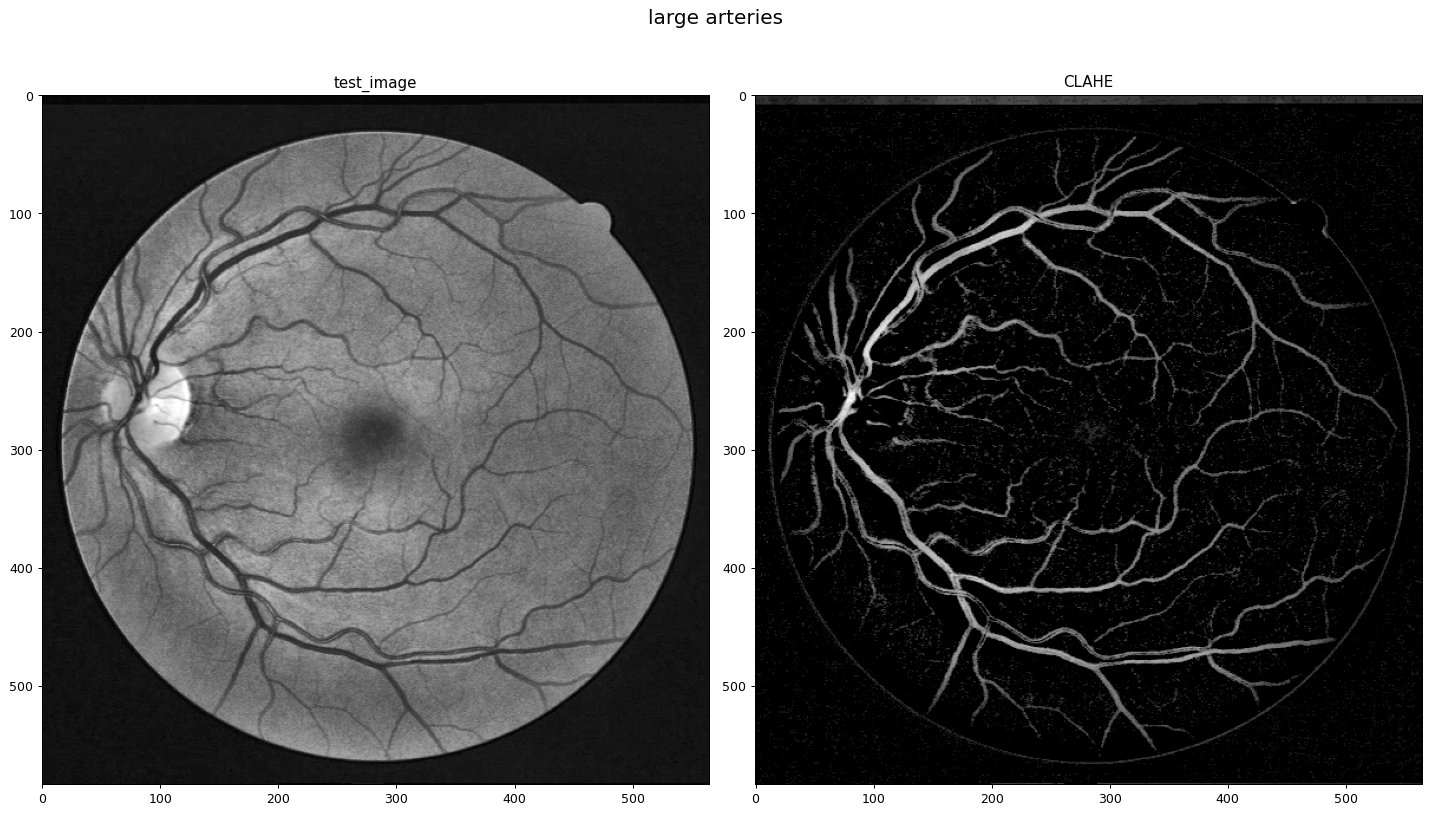

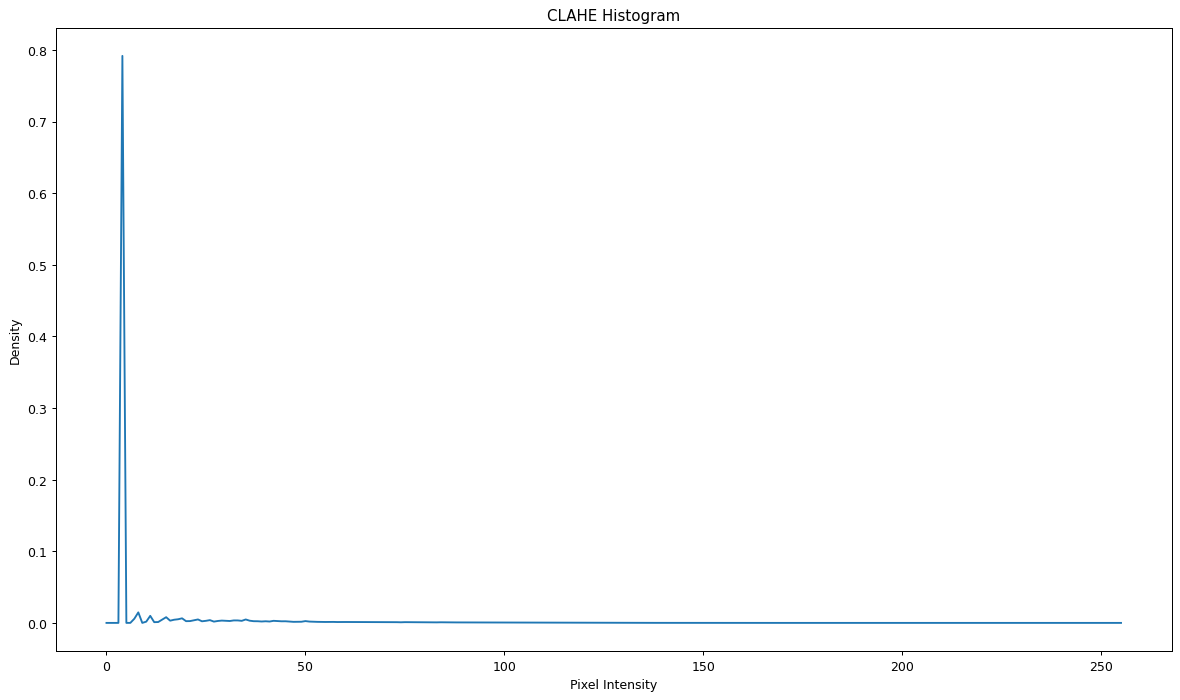

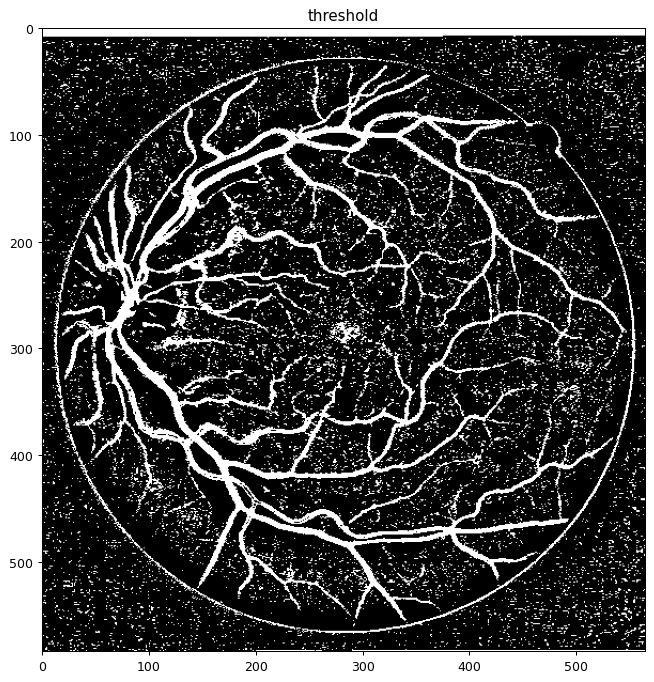

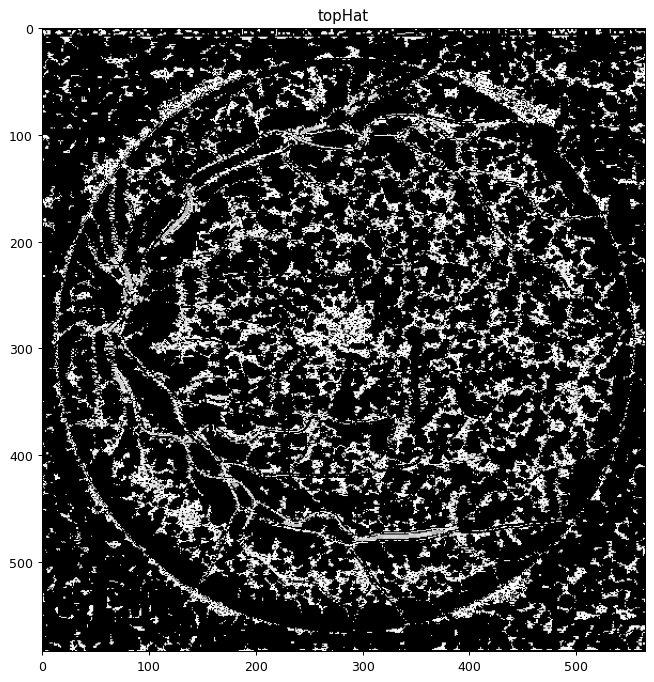

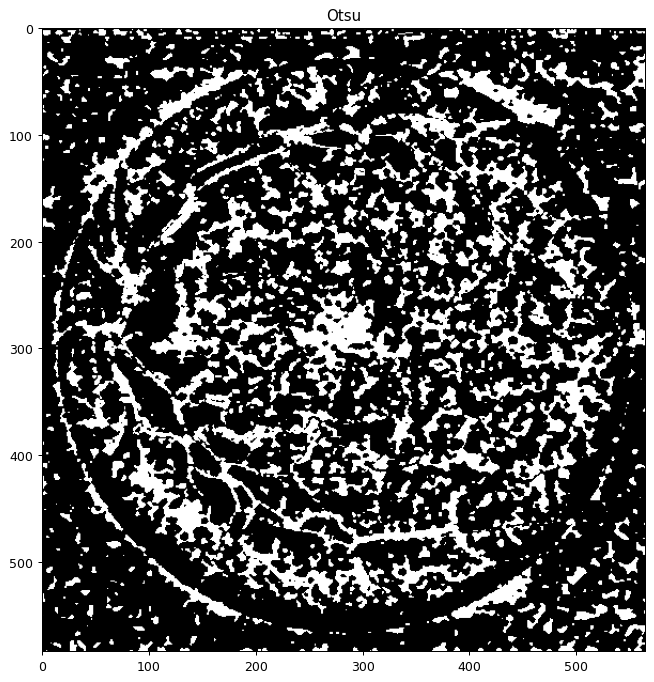

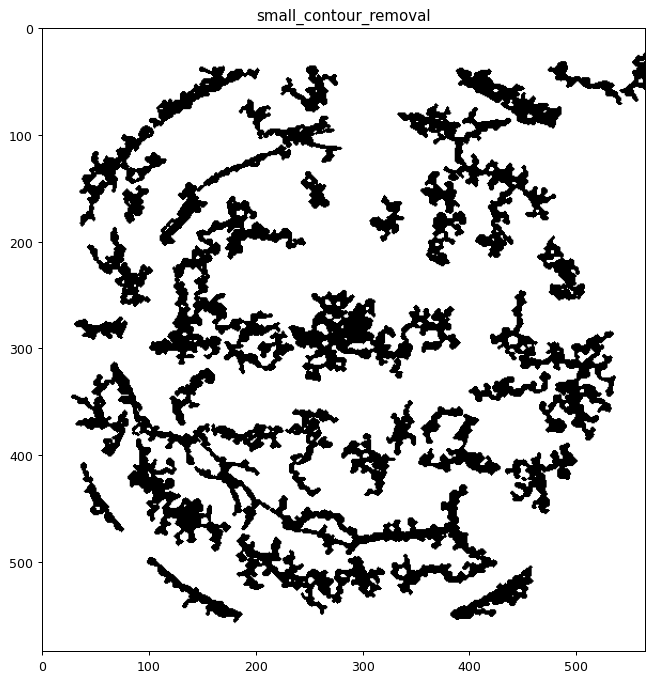

In [53]:
ex = ExtractArteries(show=True)
_ = ex.extract(input_img)